<a href="https://colab.research.google.com/github/viixne/dr-resources/blob/main/NLP_Hackathon__.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NLP hackathon

## Importing the Libraries

In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report


Data set can be found [here](https://drive.google.com/file/d/1nLe663f5ixOboXnVt8Z39h0wos3tjIoS/view?usp=sharing)

In [16]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('pp',encoding=DATASET_ENCODING , names=DATASET_COLUMNS)



In [21]:
#View the data. You can either call the name or leverage the head method. If you are using the head method try using (-1) in the number part
# And take a look at what the data would look like
# Code here
dataset.head(-1)


,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599994,4,2193579489,Tue Jun 16 08:39:00 PDT 2009,NO_QUERY,EvolveTom,"@Cliff_Forster Yeah, that does work better tha..."
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...


Hmm, looks like sentiment column has values from 0 to 4. But, its only supposed to have 2 values right. Let's first chek how many unique values does Sentiment column has.
<br>
You have a line to check that in slides.
**Hint**: Unique()

In [24]:
#Unique pulls all the unique values in a particular column
# Code here
dataset["sentiment"].unique()

array([0, 4])

Looks like we can perform some preprocessing steps and gut checks various steps would be
1. Removing unecessary columns.
2. Target labels has 0,4 as negative and positive sentiment. Let's change that
3. checking if we have equall positive and negative labels (we don't want model to take one side)
3. Perform text preprocessing operations


In [26]:
#  Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]

# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4, 1)  #Replace 4 with 1 here



<ipython-input-26-bd440a50f95c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['sentiment'] = dataset['sentiment'].replace(4, 1)  #Replace 4 with 1 here


In [27]:
type(dataset['text'])

pandas.core.series.Series

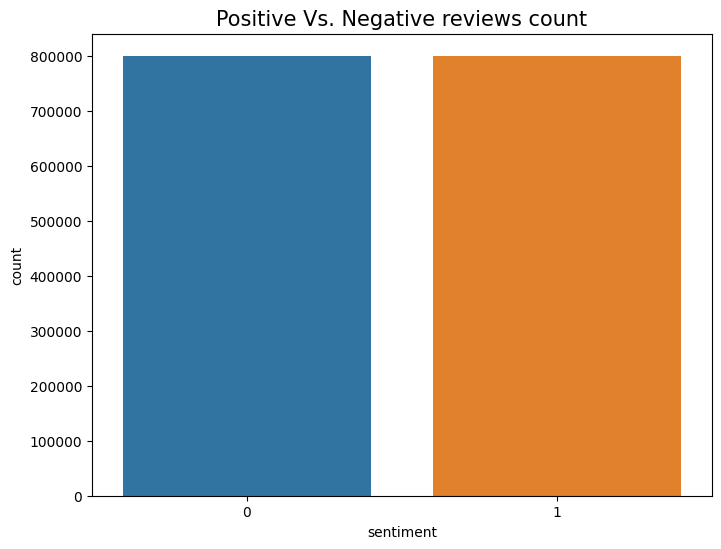

In [49]:
# checking if we have equall positive and negative labels (we don't want model to take one side)
plt.figure(figsize = (8,6))
sns.countplot(x = 'sentiment', data = dataset)  #Fill in the right values for x and data

plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()
# print(df.shape)

#In ML algorithms, its essential that target values have same distribution,
# cause if we have more positive labels, model may end up classifying all labels as positive


In [41]:
# Lets take a look at the text data that we have
dataset['text'][np.random.randint(0, 160000)]

'whooooaaa another one of those doomsday dreams!! '

We need to transform this text into a better text so that our algorithms makes better results out of it

## <a name="p3">Preprocess Text</a>
**Text Preprocessing** is traditionally an important step for **Natural Language Processing (NLP)** tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

**The Preprocessing steps taken are:**
1. **Lower Casing:** Each text is converted to lowercase.
2. **Replacing URLs:** Links starting with **"http" or "https" or "www"** are replaced by **"URL"**.
3. **Replacing Emojis:** Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. *(eg: ":)" to "EMOJIsmile")*
4. **Replacing Usernames:** Replace @Usernames with word **"USER"**. *(eg: "@Kaggle" to "USER")*
5. **Removing Non-Alphabets:** Replacing characters except Digits and Alphabets with a space.
6. **Removing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters. *(eg: "Heyyyy" to "Heyy")*
7. **Removing Short Words:** Words with length less than 2 are removed.
8. **Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. *(eg: "the", "he", "have")*
9. **Lemmatizing:** Lemmatization is the process of converting a word to its base form. *(e.g: “Great” to “Good”)*
<br>
Lemmatization is a natural language processing (NLP) technique that involves reducing words to their base or root form, known as the lemma
<br><br>
For example, consider the words "running," "ran," and "runs."  All of these words essentially means the same, we don't want our model to treat these as different words. Hence, we change these words into their base form
<br>
Thus the lemma for all of these words would be "run."

Since the dataset we have is so big, let's take a couple of texts and see how each step will change the text. As long as our function works well on a couple of paragraph texts inside a list. we can put the entire text data we have isdie a list and perform all functions at once.
<br>
So, the plan would look like this
a. Take a list with couple of RAW texts
b. See wether our function works as expected on these small list of texts

In [76]:
small_list = ["In Ipoh now. Eta 6.45pm hope the jam not too bad. Lots of trees being chopped :(. Oh well ",
              "When will `X-Men Origins:Wolverine` release in india ? looks like multiplex 'es are on strike  - no new films ?  #wolverine",
              "just finished one final ; got another one at 10! ..DEF. no sleep!",
              "@madmup We watch My Name is Earl, Reaper, Chuck, Castle and kind of Dollhouse together and @bishma also watches Sarah Connor Chronicles.",
              "@AlexAllTimeLow awwwwwwwwwwwwww pooor allexx ",
              "@dannygokey why arent on i on when u r!?!!!!?!? ",
              "3:45 am and I can't sleep.....  Maybe I'll watch something on https://instagram.com "
              ]
small_list

['In Ipoh now. Eta 6.45pm hope the jam not too bad. Lots of trees being chopped :(. Oh well ',
 "When will `X-Men Origins:Wolverine` release in india ? looks like multiplex 'es are on strike  - no new films ?  #wolverine",
 'just finished one final ; got another one at 10! ..DEF. no sleep!',
 '@madmup We watch My Name is Earl, Reaper, Chuck, Castle and kind of Dollhouse together and @bishma also watches Sarah Connor Chronicles.',
 '@AlexAllTimeLow awwwwwwwwwwwwww pooor allexx ',
 '@dannygokey why arent on i on when u r!?!!!!?!? ',
 "3:45 am and I can't sleep.....  Maybe I'll watch something on https://instagram.com "]

**Preprocessing**
1. **Step one** is conveting evey text into lower case. Write a function to convert every text in above small_list into lower case

In [81]:

def lower_case(text):
    lower_case_list = []
    for tweet in text:
        # Convert the tweet text to lowercase and save it into a new variable
        lower_text = tweet.lower()

        # Append the new variable into the lower_case list
        lower_case_list.append(lower_text)

    return lower_case_list
#small_list = ["This is a Tweet.", "Another tweet.", "Python is fun!"]
case_lower = lower_case(small_list)

# Print the original list and the list after converting to lowercase
print("Text before conversion to lowercase:")
print(small_list)
print()
print("Text after conversion to lowercase:")
print(case_lower)




Text before conversion to lowercase:
['In Ipoh now. Eta 6.45pm hope the jam not too bad. Lots of trees being chopped :(. Oh well ', "When will `X-Men Origins:Wolverine` release in india ? looks like multiplex 'es are on strike  - no new films ?  #wolverine", 'just finished one final ; got another one at 10! ..DEF. no sleep!', '@madmup We watch My Name is Earl, Reaper, Chuck, Castle and kind of Dollhouse together and @bishma also watches Sarah Connor Chronicles.', '@AlexAllTimeLow awwwwwwwwwwwwww pooor allexx ', '@dannygokey why arent on i on when u r!?!!!!?!? ', "3:45 am and I can't sleep.....  Maybe I'll watch something on https://instagram.com "]

Text after conversion to lowercase:
['in ipoh now. eta 6.45pm hope the jam not too bad. lots of trees being chopped :(. oh well ', "when will `x-men origins:wolverine` release in india ? looks like multiplex 'es are on strike  - no new films ?  #wolverine", 'just finished one final ; got another one at 10! ..def. no sleep!', '@madmup we wat

2. **Step2** is replacing URL's. We barely see any URL's in a comment. URL doesn't say much about emotion of the text, also it is a bit hard to encode URL's into our algorithms.
<br>
Hence, we replace all links with URL text
<br>
Can you comeup with a function to do that?
Make sure to pass the text you obtained from step1 of preprocessing

In [85]:
def remove_url(text):
      url_removed = []
      urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"

      #Write your code here, its similar to function in step 1. But instead of replace, we make use of re.sub method
      for tweet in text:
        without = re.sub(urlPattern, 'URL', tweet)
        url_removed.append(without)
        return url_removed
        url_removed = removed_url(case_lower)

print("Text before step 2: ")
print(case_lower)
print()
print("Text after step 2: ")

print(url_removed)

# You'll see the change in last sentence as we only have URL in last sentence

Text before step 2: 
['in ipoh now. eta 6.45pm hope the jam not too bad. lots of trees being chopped :(. oh well ', "when will `x-men origins:wolverine` release in india ? looks like multiplex 'es are on strike  - no new films ?  #wolverine", 'just finished one final ; got another one at 10! ..def. no sleep!', '@madmup we watch my name is earl, reaper, chuck, castle and kind of dollhouse together and @bishma also watches sarah connor chronicles.', '@alexalltimelow awwwwwwwwwwwwww pooor allexx ', '@dannygokey why arent on i on when u r!?!!!!?!? ', "3:45 am and i can't sleep.....  maybe i'll watch something on https://instagram.com "]

Text after step 2: 
None


**Step3**:- Replacing Emojis: Sometimes in text people tend to express their emotions in emoji's instead of words, its hard for our model to take those symbols into consideration. But, we can't simply remove these emojis, cause they contains emotions. Hence we replace these emoji symbols with a emoji word.
<br>
If we have ':)' emoji in text, it means "smile". Hence we will replace it with "EMOJIsmile".

How do we write a function to do so. Ofcourse, input to this function would be the text we got from step 2

In [98]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

def replace_emojis(text):
    emoji_replaced = []
    for tweet in text:
        for emoji, replacement in emojis.items():
            # Replace the emoji with its corresponding text
            tweet = tweet.replace(emoji, replacement)
        emoji_replaced.append(tweet)
    return emoji_replaced

# Assuming url_removed is defined somewhere in your code
url_removed = ["This is a tweet with a :)", "Another tweet with :-(", "I am a cat =^.^="]

# Call the replace_emojis function and store the result in emoji_replaced
emoji_replaced = replace_emojis(url_removed)

# Print the text before and after replacing emojis
print("Text before replacing emojis:")
print(url_removed)
print()
print("Text after replacing emojis:")
print(emoji_replaced)


Text before replacing emojis:
['This is a tweet with a :)', 'Another tweet with :-(', 'I am a cat =^.^=']

Text after replacing emojis:
['This is a tweet with a smile', 'Another tweet with sad', 'I am a cat cat']


**Step4:** Replacing Usernames (@rajesh).
<br> Name has nothing to do with emotions, our model should have same emotion value for 'Luke' or 'Jimmie' or 'Bissrat'. Hence, we repalce all the usernames with just the value 'USER'.
<br>
In comments we usually mentions someone by using @. Hence, one simple way to replace names is to replace words that starts with @ by 'USER'
<br>
Write a function for the above logic. We will input step 3 text here



In [108]:
def replace_username(text):
      userPattern  = '@[^\s]+'
      username_replaced = []

      #Write your code here
      return username_replaced

      for tweet in text:
        for USER, replacement in user.items():
          user = username_replaced(USER, replacement)
          username_replaced.append(user)
          return username_replaced

username_replaced = replace_emojis(url_removed)
print("Text before step 4: ")

print(emoji_replaced)
print()
print("Text after step 4: ")

print(username_replaced)

Text before step 4: 
['This is a tweet with a smile', 'Another tweet with sad', 'I am a cat cat']

Text after step 4: 
['This is a tweet with a smile', 'Another tweet with sad', 'I am a cat cat']


**Step5:** Removing Non-Alphabets:
<br>
One of the limitations of our algortihms is that it can only convert text which contains (a to z) or (A to Z) or (0 to 9). Stuff like (;) or (') or (!) cannot be converted.
<br>
Hence we need to replace Non-Alphabets into " ".
<br>
With the help of regular expression provided. Implement a function to do this step. Input here would be the values from step 4.


In [110]:
def remove_non_alphabets(text):
      alphaPattern = "[^a-zA-Z0-9]"
      non_alphabets_removed = []
      for tweet in text:
        tweet = re.sub(alphaPattern, " ", tweet)
        non_alphabets_removed.append(tweet)
      return non_alphabets_removed
non_alphabets_removed = remove_non_alphabets(username_replaced)
print("Text before step 5: ")

print(username_replaced)
print()
print("Text after step 5: ")

print(non_alphabets_removed)

Text before step 5: 
['This is a tweet with a smile', 'Another tweet with sad', 'I am a cat cat']

Text after step 5: 
['This is a tweet with a smile', 'Another tweet with sad', 'I am a cat cat']


**Step 6:** Removing Consecutive letters:
Inorder to feed the text data into our model training, we will convert text data into numbers. We do so by creating an individual column for each existing word.
<br>
Now, in comments sometimes people tend to type "Heyyyyyyy" instead of "Heyy" or "Awwwwwwwww" instead of "Aww". There is no point in creating two different columns for these kind of words/
<br>Hence, any word with 3 or more consecutive letters are replaced by 2 letters. (eg: "Heyyyy" to "Heyy")
<br>
<br>
Write a function to implement the above step, you will be provided with 2 regular expressions as a helper code. Also, input here would be text values from step 5

In [111]:
def trim_multi_letters(text):
      sequencePattern   = r"(.)\1\1+"
      seqReplacePattern = r"\1\1"
      multi_letters_removed = []
      for tweet in text:
        # Replace 3 or more consecutive letters by 2 letters.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        multi_letters_removed.append(tweet)
      return multi_letters_removed
multi_letters_removed = trim_multi_letters(non_alphabets_removed)

print("Text before step 6: ")
print(non_alphabets_removed)
print()
print("Text after step 5: ")
print(multi_letters_removed)

Text before step 6: 
['This is a tweet with a smile', 'Another tweet with sad', 'I am a cat cat']

Text after step 5: 
['This is a tweet with a smile', 'Another tweet with sad', 'I am a cat cat']


**Step 7:** Removing Short Words:
We barely see any single letter words that adds any emotion into a comment. Creating a new column for them is not worth the memory resources.
<br>
Write a function to replace words with less than 2 letters. Input here would be the text we obtained from step 6.
<br>

In [112]:
def remove_single_letters(text):
    text_without_single_letters = []
    # Define a pattern to match words with less than 2 letters
    shortWordPattern = r'\b\w{1}\b'
    for tweet in text:
      tweet = re.sub(shortWordPattern, '', tweet)
      text_without_single_letters.append(tweet)
    return text_without_single_letters

# Applying the function to remove single-letter words
text_without_single_letters = remove_single_letters(multi_letters_removed)

# Print the results
print("Text before step 6:")
print(multi_letters_removed)
print()
print("Text after step 7:")
print(text_without_single_letters)


Text before step 6:
['This is a tweet with a smile', 'Another tweet with sad', 'I am a cat cat']

Text after step 7:
['This is  tweet with  smile', 'Another tweet with sad', ' am  cat cat']


**Step 8**: Stopword removal:
<br>
Stopwords like "and", "the", "are", "on" exits in both negative and positive reviews. Hence, they don't add much importance when it comes to emotion detection
<br>
W'll give you a list of stop words, write a function to check and remove those stopwords in a given list of texts. Here the input would the text value from step 7


In [113]:
#Something wrong with this logic
## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

def remove_stopwords(text):
      stopwords_removed = []
      for tweet in text:
        for word in stopwordlist:
           tweet = re.sub(r'\b' + word + r'\b', '', tweet)
        stopwords_removed.append(tweet)
      return stopwords_removed


stopwords_removed = remove_stopwords(text_without_single_letters)

print("Text before step 7: ")
print(text_without_single_letters)
print()
print("Text after step 7: ")

print(stopwords_removed)

Text before step 7: 
['This is  tweet with  smile', 'Another tweet with sad', ' am  cat cat']

Text after step 7: 
['This   tweet   smile', 'Another tweet  sad', '   cat cat']


**Step 9**: Lemmatization
Lemmatization is the process of converting a word to its base form. We have words like run, ran, running. These words mean the same, so we don't want our model to give them new columns. Hence, we lemmatize them to basically get the base words of the text.
<br>
I.e we convert words like run, ran, running into their base form run.
<br>
using the lemmatize method from slides, write a function to lemmatize the input text from step 8
<br>
**Hint** for each text, you have split the entire text into list of words, lemmatize each word, then append each new word to form a new sentence.

In [114]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [115]:
import re
from nltk.stem import WordNetLemmatizer

def lemmatize_text(text):
  wordLemm = WordNetLemmatizer()
  baseform_text = []
  for tweet in text:
    tweetwords = ''
    for word in tweet.split():
      if len(word) > 1:
      # Lemmatizing the word.
        word = wordLemm.lemmatize(word)
        tweetwords += (word + ' ')
    baseform_text.append(tweetwords)

  return baseform_text




baseform_text = lemmatize_text(stopwords_removed)

print("Text before step 8: ")
print(stopwords_removed)
print()
print("Text after step 8: ")

print(baseform_text)


Text before step 8: 
['This   tweet   smile', 'Another tweet  sad', '   cat cat']

Text after step 8: 
['This tweet smile ', 'Another tweet sad ', 'cat cat ']
